# Tutorial 2: Analyzing Neural Networks

In this part of the tutorial we'll use the manifold capacity framework to analyze the representations learned by neural networks as we train them on classification tasks. The studies we'll do in this tutorial are inspired by those presented in **[Separability and geometry of object manifolds in deep neural networks](https://www.nature.com/articles/s41467-020-14578-5)**, the follow-up to the original manifold capacity paper that applied the theoretical ideas to real-world machine learning problems. 

We'll use the official code implementation for capacity calculations, so you won't need to copy over your work from Tutorial 1 (but feel free to use it if you want!). We'll be analyzing image classifiers and investigating how the geometry of image representations changes as they are passed through the layers of a trained network.

**Run these cells first!**

In [ ]:
### GOOGLE COLAB SETUP -- ONLY RUN IF WORKING IN COLAB ###
! git clone https://github.com/SamBT/manifold-capacity-tutorial-iaifi25 
%cd /content/manifold-capacity-tutorial-iaifi25/
! pip install -r requirements.txt

In [ ]:
### GOOGLE COLAB SETUP -- RUN THIS CELL AFTER THE KERNEL RESTARTS ###
%cd /content/manifold-capacity-tutorial-iaifi25/

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm import tqdm
from helpers import manifold_analysis_corr, manifold_analysis, extractor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2.1 - MNIST analysis
Let's start simple by training a classifier on $28 \times 28$ images of handwritten digits from MNIST. We'll train both a standard MLP and a convolutional neural network and see how they differ using our manifold capacity tools. 

Let's start with the boring stuff -- dataloaders, train/test/val splits, etc

In [2]:
# Define the transformations
mnist_mean = 0.1307
mnist_std = 0.3081
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mnist_mean,), (mnist_std,))  # MNIST mean and std
])

# Load datasets
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

# Split train into train and validation
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# useful for later
mnist_labels = np.arange(10)

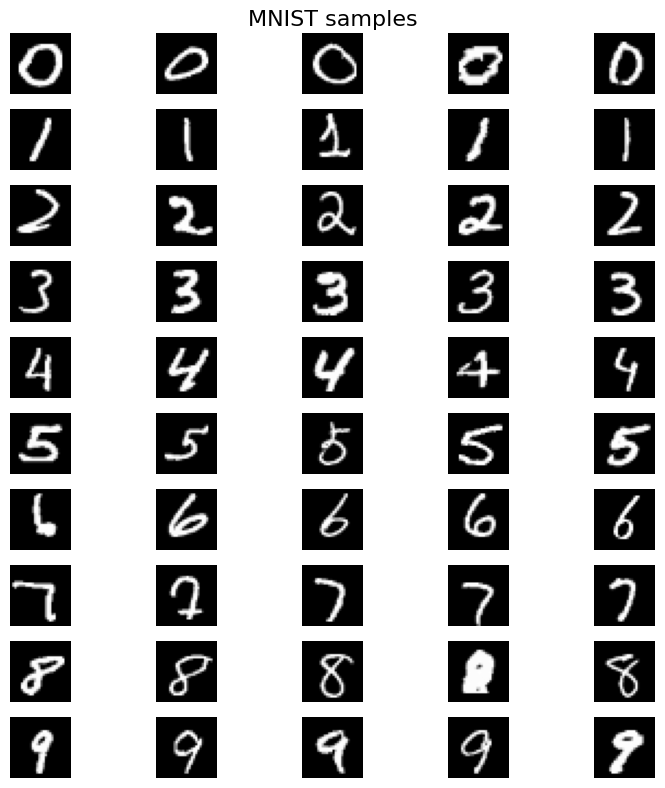

In [3]:
# Define a function to visualize samples from each class
def visualize_mnist_samples(dataset, num_samples_per_class=5):
    # Create a figure with subplots for each class (0-9)
    fig, axes = plt.subplots(10, num_samples_per_class, figsize=(8, 8))
    
    # Dictionary to keep track of samples per class
    class_samples = {i: 0 for i in range(10)}
    
    # Iterate through the dataset until we have enough samples for each class
    for idx in range(len(dataset)):
        # Get image and label
        img, label = dataset[idx]
        
        # If we haven't collected enough samples for this class
        if class_samples[label] < num_samples_per_class:
            # Convert tensor to numpy and reshape
            img_np = img.squeeze().numpy()
            
            # Plot the image
            axes[label, class_samples[label]].imshow(img_np, cmap='gray')
            axes[label, class_samples[label]].axis('off')
            
            # Increment count for this class
            class_samples[label] += 1
        
        # Check if we have collected enough samples for all classes
        if all(count >= num_samples_per_class for count in class_samples.values()):
            break
    
    # Set figure title
    plt.suptitle('MNIST samples', fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

# Visualize samples from each class
visualize_mnist_samples(train_dataset)

Now let's define a basic MLP for classification

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim, activation=nn.SiLU(), dropout=0.0):
        super(MLP, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(activation)
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, output_dim))
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        if len(x.shape) > 2:
            x = x.view(x.size(0), -1) # flatten if given multidimensional input (image)
        return self.model(x)

Next we define a generic training loop:

In [5]:
def train_model(model, train_loader, val_loader, epochs=30, patience=5, learning_rate=1e-3, weight_decay=1e-5):
    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # For tracking metrics
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_weights = None
    
    # Training loop
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # Training phase
        model.train()
        epoch_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_train_loss = epoch_loss / len(train_loader)
        epoch_train_acc = correct / total
        train_losses.append(epoch_train_loss)
        
        # Validation phase
        model.eval()
        epoch_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Statistics
                epoch_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_val_loss = epoch_loss / len(val_loader)
        epoch_val_acc = correct / total
        val_losses.append(epoch_val_loss)
        
        # Update tqdm postfix with metrics
        tqdm.write(f"Epoch {epoch+1}/{epochs} - Train loss: {epoch_train_loss:.4f}, Train acc: {epoch_train_acc:.4f}, "
                  f"Val loss: {epoch_val_loss:.4f}, Val acc: {epoch_val_acc:.4f}")
        
        # Check if this is the best model
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_weights = model.state_dict().copy()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            
        # Early stopping
        if patience > 0 and epochs_no_improve >= patience:
            print("Early stop")
            break
    
    # Load the best model weights
    if best_model_weights:
        model.load_state_dict(best_model_weights)
    
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    return model, train_losses, val_losses

### 2.1.1 - Analyze an MLP trained on MNIST

First things first, define an `MLP` (with whatever hyperparameters you want) and, **before training it** use the `extractor` helper function (imported above) to evaluate internal activations on a sample of test set images (1000 or so should be fine, no need to do the whole dataset). The extractor function returns the following dictionary:

```
activations = {
   "inputs": your input data (flattened), shape (B,d_input),
   "labels": sample labels,
   for i = 1,..., n_layers:
       "linear_i", "conv_i", etc.: activations, # name depends on layer type
}
```

#### **FILL IN CODE**

In [6]:
# Initialize an MLP with whatever hyperparameters you think are appropriate
# the output dimension should be 10, since we're doing MNIST classification
input_dim = 28 * 28  # MNIST images are 28x28 pixels
hidden_dims = [1024, 512, 256, 128]
output_dim = 10  # 10 classes (digits 0-9)
mnist_model = MLP(
    input_dim=input_dim,
    hidden_dims=hidden_dims,
    output_dim=output_dim,
    activation=nn.ReLU(),
    dropout=0.2
)

In [7]:
# Define a dataloader for the test set and extract activations for 1000 test samples
num_test_samples = 1000
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=num_test_samples)
test_images, test_labels = next(iter(test_loader))
layer_types = ['Linear'] # type of layers to extract activations from; our MLP only has Linear layers
activations_untrained, layer_names = extractor(mnist_model, test_images, test_labels, layer_types=layer_types)

Before training, let's use our manifold capacity tools to analyze the input data and the untrained MLP. Samples from each MNIST digit (10 classes, digits 0-9) correspond to our manifold point clouds. We want to compute the manifold capacity, radius, and dimension for each of these classes at each level of processing (input data, 1st layer activations, 2nd layer activations, etc.) and see how they evolve.

**Question**: The network is untrained -- do you expect to see any trends in capacity/radius/dimension as we pass through layers of the network?

### **FILL IN CODE**

In [8]:
def capacity_analysis(activations, num_per_label=20):
    # Get a sorted list of MNIST labels
    labels = sorted(list(set(activations['labels'])))

    alphas = {l:[] for l in labels}
    radii = {l:[] for l in labels}
    dims = {l:[] for l in labels}
    mean_alphas = []
    mean_radii = []
    mean_dims = []

    # loop through the raw inputs + each layer of the network
    for layer_name in activations.keys():
        if layer_name == 'labels':
            continue
        print(f"Processing activations for layer: {layer_name}")
        # retrieve corresponding activations
        acts = activations[layer_name]

        # construct point clouds for each mnist class
        point_clouds = []
        for l in labels:
            mask = activations['labels'] == l
            point_clouds.append(acts[mask][:num_per_label].T) # limit the number of samples per class to num_per_label
        
        # compute manifold capacity, radius, and dimension 
        alpha, radius, dim = manifold_analysis(point_clouds, kappa=0, n_t=300)

        # fill dictionaries with label-specific results
        for i,l in enumerate(labels):
            alphas[l].append(alpha[i])
            radii[l].append(radius[i])
            dims[l].append(dim[i])

        # compute mean values for alpha, radius, and dimension across the mnist classes
        mean_alpha = 1.0/np.mean(1.0/alpha)
        mean_radius = np.mean(radius)
        mean_dim = np.mean(dim)
        
        mean_alphas.append(mean_alpha)
        mean_radii.append(mean_radius)
        mean_dims.append(mean_dim)
    return alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels

In [9]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations_untrained, num_per_label=20)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Linear
Processing activations for layer: layer_4_Linear
Processing activations for layer: layer_6_Linear
Processing activations for layer: layer_8_Linear
Processing activations for layer: layer_10_Linear


Now let's plot capacity, radius, and dimension as a function of "depth" -- i.e. the x-axis will be the layer of the MLP, with the first entry corresponding to raw inputs

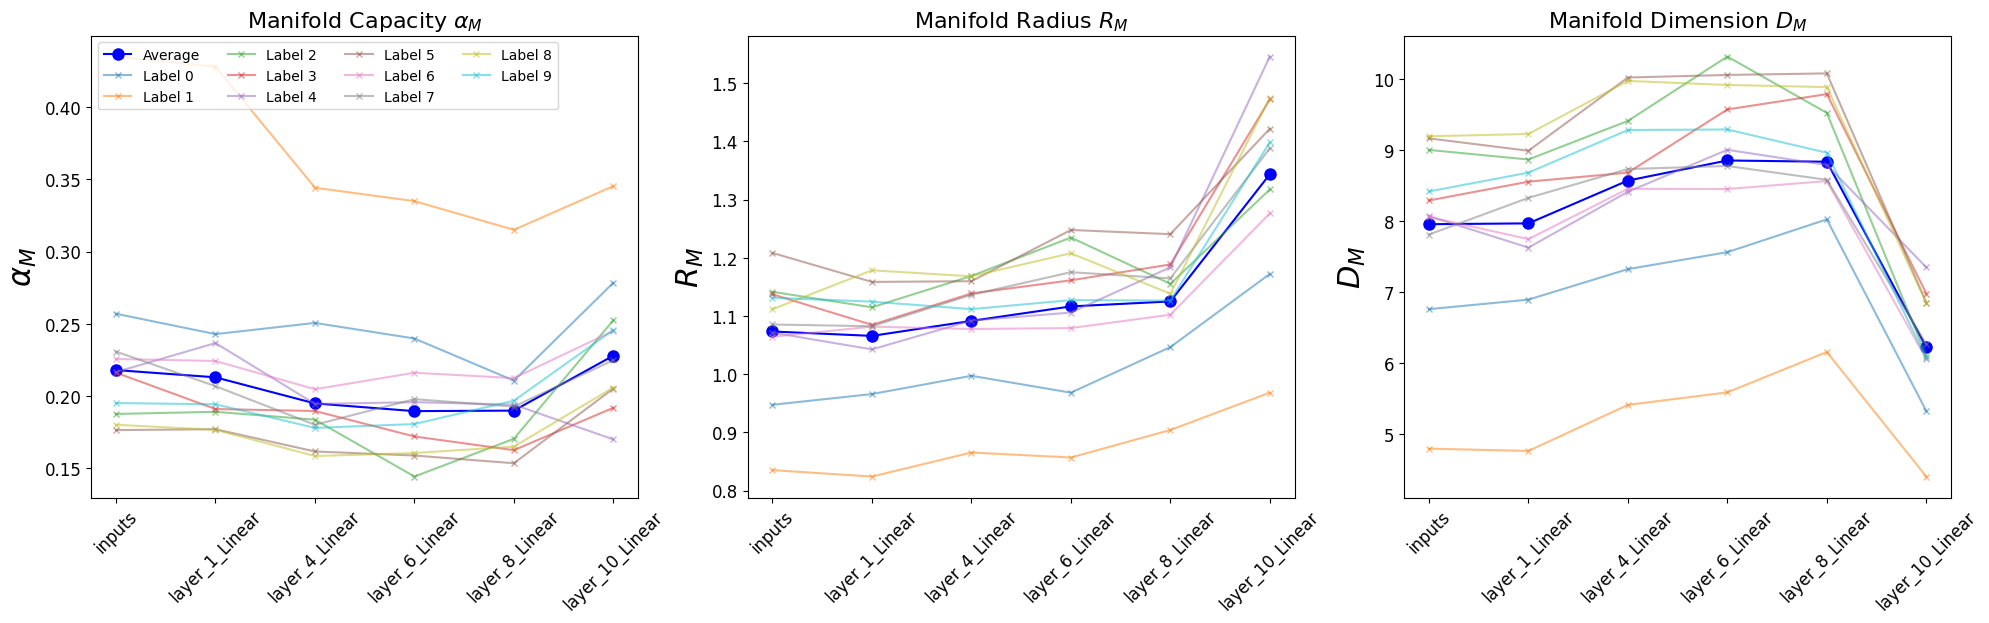

In [10]:
from helpers.plotting import network_capacity_summary

network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

There shouldn't be any intelligible trend here, but this is to be expected -- we haven't trained the network yet! Note that the average capacity is pretty low, indicating that the raw pixel values (and a random processing of them by an untrained MLP) is not a super efficient way to encode them! 

**Question**: do you notice anything about the capacity/radius/dimension of the individual digits? What about the number 1?

**Question**: why does the dimension dip in the final layer?

Now, let's train the model!

Training Progress:   0%|          | 0/20 [00:00<?, ?it/s]

Training Progress:   5%|▌         | 1/20 [00:07<02:30,  7.93s/it]

Epoch 1/20 - Train loss: 0.7171, Train acc: 0.7770, Val loss: 0.2295, Val acc: 0.9308


Training Progress:  10%|█         | 2/20 [00:15<02:21,  7.86s/it]

Epoch 2/20 - Train loss: 0.2036, Train acc: 0.9396, Val loss: 0.1409, Val acc: 0.9563


Training Progress:  15%|█▌        | 3/20 [00:23<02:13,  7.83s/it]

Epoch 3/20 - Train loss: 0.1334, Train acc: 0.9609, Val loss: 0.1103, Val acc: 0.9665


Training Progress:  20%|██        | 4/20 [00:30<02:00,  7.52s/it]

Epoch 4/20 - Train loss: 0.0994, Train acc: 0.9702, Val loss: 0.1050, Val acc: 0.9687


Training Progress:  25%|██▌       | 5/20 [00:39<01:58,  7.89s/it]

Epoch 5/20 - Train loss: 0.0809, Train acc: 0.9753, Val loss: 0.0828, Val acc: 0.9752


Training Progress:  30%|███       | 6/20 [00:46<01:46,  7.63s/it]

Epoch 6/20 - Train loss: 0.0631, Train acc: 0.9812, Val loss: 0.0828, Val acc: 0.9762


Training Progress:  35%|███▌      | 7/20 [00:53<01:36,  7.41s/it]

Epoch 7/20 - Train loss: 0.0513, Train acc: 0.9848, Val loss: 0.0756, Val acc: 0.9783


Training Progress:  40%|████      | 8/20 [01:00<01:27,  7.27s/it]

Epoch 8/20 - Train loss: 0.0413, Train acc: 0.9873, Val loss: 0.0837, Val acc: 0.9782


Training Progress:  45%|████▌     | 9/20 [01:07<01:21,  7.41s/it]

Epoch 9/20 - Train loss: 0.0392, Train acc: 0.9886, Val loss: 0.0771, Val acc: 0.9789


Training Progress:  50%|█████     | 10/20 [01:14<01:13,  7.30s/it]

Epoch 10/20 - Train loss: 0.0318, Train acc: 0.9901, Val loss: 0.0803, Val acc: 0.9787


Training Progress:  55%|█████▌    | 11/20 [01:22<01:05,  7.22s/it]

Epoch 11/20 - Train loss: 0.0287, Train acc: 0.9906, Val loss: 0.0799, Val acc: 0.9796


Training Progress:  55%|█████▌    | 11/20 [01:29<01:12,  8.11s/it]

Epoch 12/20 - Train loss: 0.0298, Train acc: 0.9902, Val loss: 0.0765, Val acc: 0.9799
Early stop


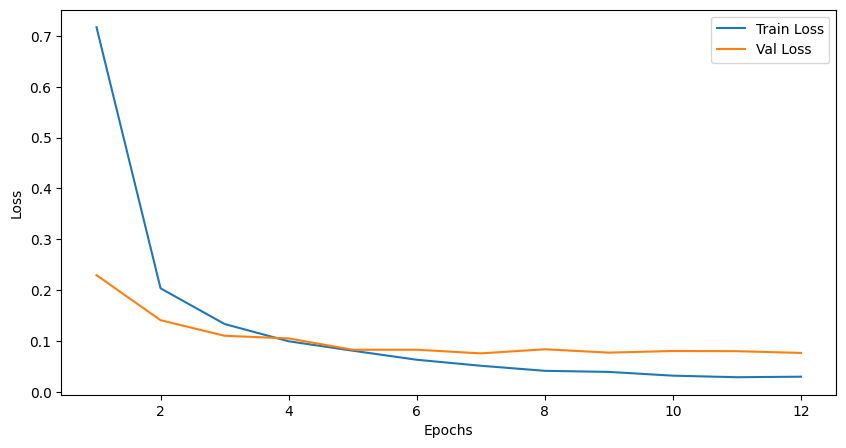

In [11]:
# define train/val/test loaders, choose a batch size
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Train the model
trained_model, train_losses, val_losses = train_model(
    model=mnist_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,
    patience=5,
    learning_rate=0.001
)

Now let's repeat the same analysis we did above

### FILL IN CODE

In [12]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_images, test_labels = next(iter(test_loader))
layer_types = ['Linear']
activations_trained, layer_names = extractor(trained_model, test_images, test_labels, layer_types=layer_types)
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations_trained, num_per_label=20)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Linear
Processing activations for layer: layer_4_Linear
Processing activations for layer: layer_6_Linear
Processing activations for layer: layer_8_Linear
Processing activations for layer: layer_10_Linear


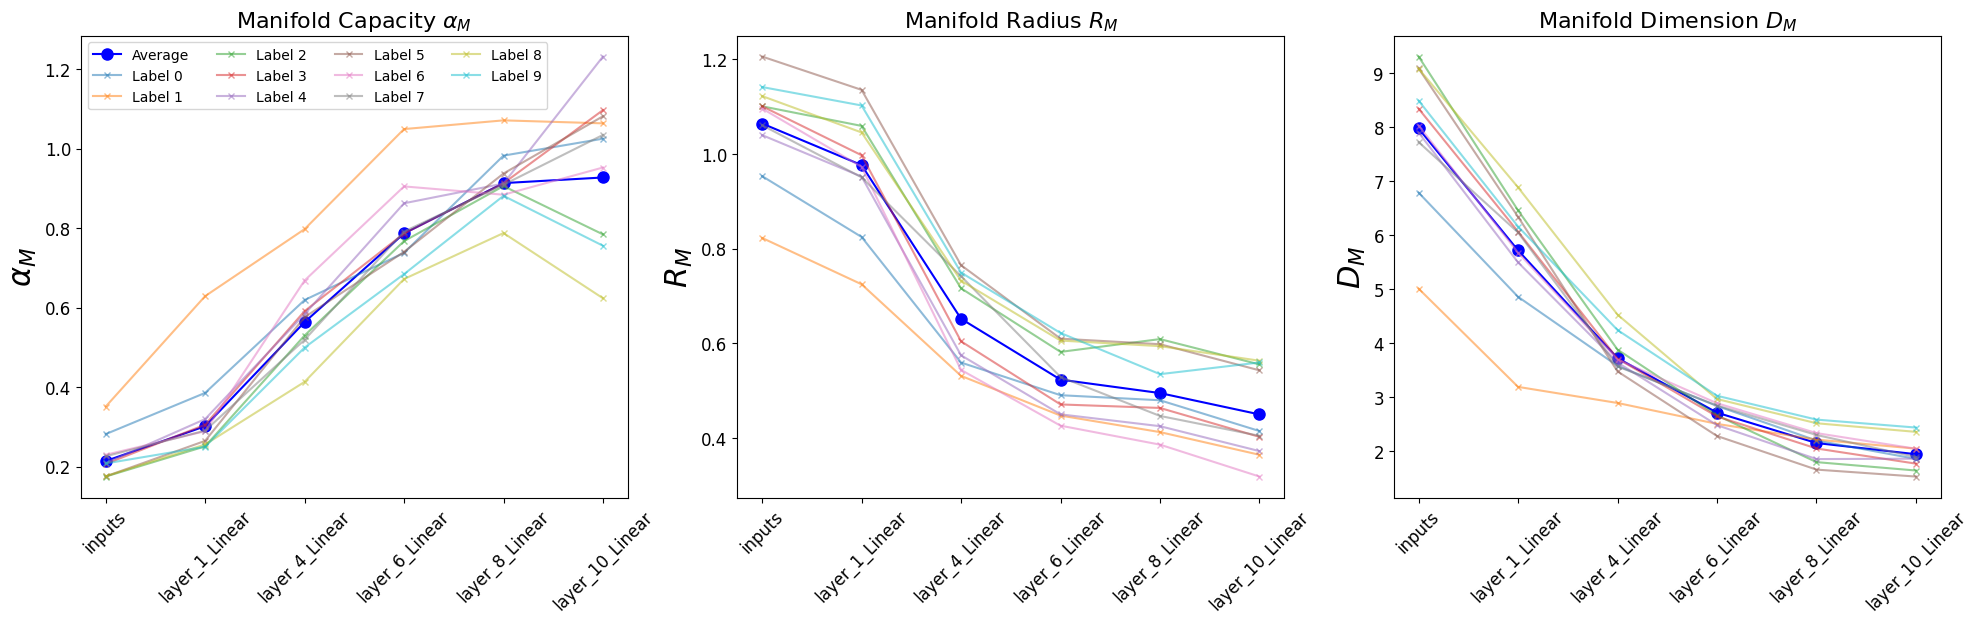

In [13]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,mnist_labels)

What differences do you notice relative to the untrained model? Does this make sense? What can we conclude about the way the neural network has learned to process input images from each digit class?

### 2.1.2 - Augmentation manifolds
As we discussed in lecture and Tutorial 1, one of the motivating problems for manifold capacity theory is invariant object recognition - our ability to quickly identify classes of objects in diverse contexts. This suggests that we learn efficient representations of **augmentation manifolds**, i.e. the collection of neural activations corresponding to many different views of an objects. We can directly probe these manifolds using our trained MNIST classifier. We'll do the following:

1. Choose some parametrized family of image augmentations

2. Take one exemplar from each digit, and for each generate an augmentation manifold by sampling some range of transformations.

3. Run our manifold capacity analysis on the augmentation manifolds across the layers of our neural network, and see if they become any more/less compact.

We'll try this for two kinds of augmentation: shears and rotations.

Let's begin with shears

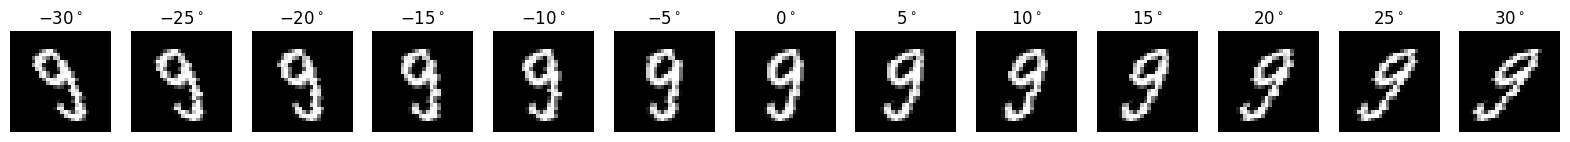

In [14]:
from torchvision.transforms.functional import affine

img,label = train_dataset[271] # choose a random image

shears = np.arange(-30,35,5) # sample some shear angles

fig,axes = plt.subplots(1, len(shears), figsize=(20, 5))
for i, shear in enumerate(shears):
    # Apply shear transformation
    img_sheared = affine(img, angle=0, translate=(0, 0), scale=1.0, shear=shear, fill=-mnist_mean/mnist_std)
    axes[i].imshow(img_sheared.squeeze().numpy(), cmap='gray')
    axes[i].set_title(f'${shear}^\\circ$',fontsize=12)
    axes[i].axis('off')

Now let's curate a dataset. We want to take one exemplar from each digit class and create an associated augmentation manifold of shear transformations (note that this is different from before, where each class point cloud was just a collection of randomly sampled images from that class)

In [15]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
test_images, test_labels = next(iter(test_loader))
one_per_class = [test_images[test_labels == l][0] for l in mnist_labels]

# apply shears to each exemplar, create new label set
shears = np.arange(-30, 32, 2) # define some reasonably dense sampling of shear angles; you don't need too many, maybe 20-30 
shear_imgs = []
shear_labels = []
for shear in shears:
    for img, label in zip(one_per_class, mnist_labels):
        # Apply shear transformation
        img_sheared = affine(img, angle=0, translate=(0, 0), scale=1.0, shear=shear, fill=-mnist_mean/mnist_std)
        shear_imgs.append(img_sheared.unsqueeze(0))  # add batch dimension
        shear_labels.append(label)
shear_imgs = torch.cat(shear_imgs, dim=0)
shear_labels = torch.tensor(shear_labels)

Let's analyze the augmentation manifolds using the tools we wrote above and our trained mnist classifier

In [16]:
activations_shear, layer_names = extractor(trained_model, shear_imgs, shear_labels, layer_types=['Linear'])
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations_shear)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Linear
Processing activations for layer: layer_4_Linear
Processing activations for layer: layer_6_Linear
Processing activations for layer: layer_8_Linear
Processing activations for layer: layer_10_Linear


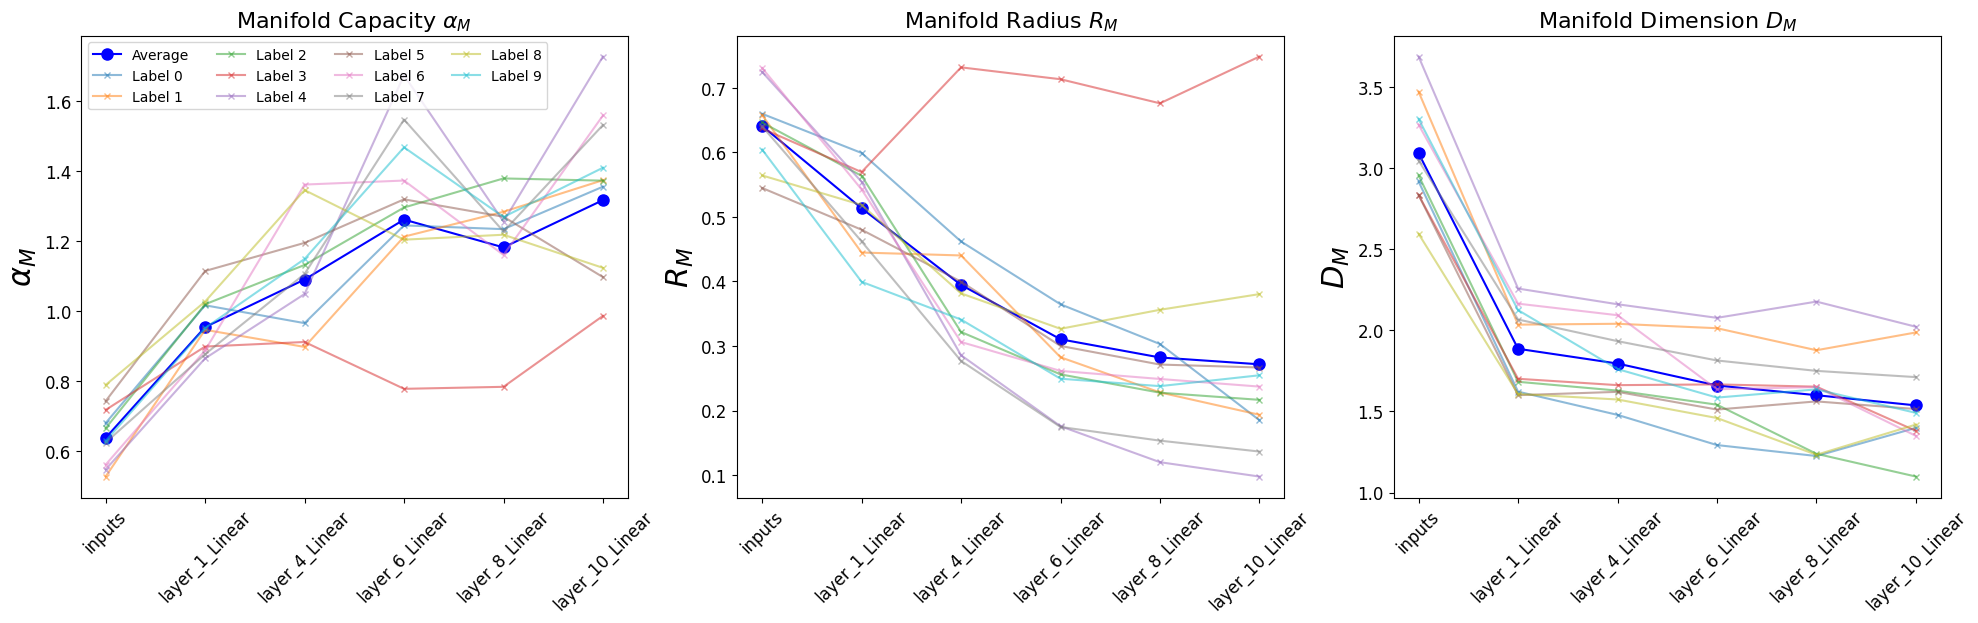

In [17]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,mnist_labels)

What do you notice about these results? Is it what you expected? Shears are fairly "natural" transformations for handwritten digits -- everyone writes numbers a little differently, and a sharply angled "1" or "7" is not out of the realm of possibility (and probably exists in the MNIST training set!). 

**Exercise**: Repeat this analysis with rotations between e.g. -90 and 90 degrees. These are a more "aggressive" augmentation relative to shears, and relative to the range of variation for each digit that the model would've seen in training. You can do this using the same affine transformation function we used above, just change the arguments. What's different this time?

#### **FILL IN CODE**

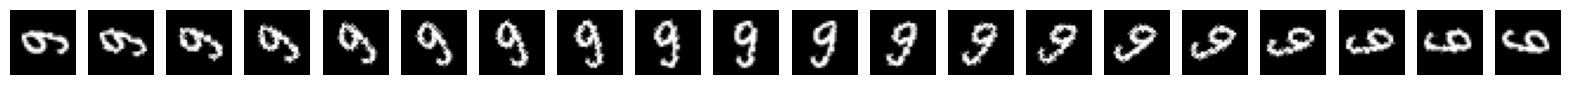

In [18]:
from torchvision.transforms.functional import affine
img,label = train_dataset[271]
angles = list(np.linspace(-90,90,20))
fig,axes = plt.subplots(1, len(angles), figsize=(20, 5))
for i, angle in enumerate(angles):
    # Apply shear transformation
    img_sheared = affine(img, angle=angle, translate=(0, 0), scale=1.0, shear=0, fill=-mnist_mean/mnist_std)
    axes[i].imshow(img_sheared.squeeze().numpy(), cmap='gray')
    axes[i].axis('off')

In [19]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100)
test_images, test_labels = next(iter(test_loader))
one_per_class = [test_images[test_labels == l][0] for l in mnist_labels]

# apply shears to each exemplar, create new label set
angles = np.linspace(-90,90,20)
rot_imgs = []
rot_labels = []
for angle in angles:
    for img, label in zip(one_per_class, mnist_labels):
        # Apply rotation transformation
        img_rotated = affine(img, angle=angle, translate=(0, 0), scale=1.0, shear=0, fill=-mnist_mean/mnist_std)
        rot_imgs.append(img_rotated.unsqueeze(0))  # add batch dimension
        rot_labels.append(label)
rot_imgs = torch.cat(rot_imgs, dim=0)
rot_labels = torch.tensor(rot_labels)

In [21]:
activations_rot, layer_names = extractor(trained_model, rot_imgs, rot_labels, layer_types=['Linear'])
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations_rot)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Linear
Processing activations for layer: layer_4_Linear
Processing activations for layer: layer_6_Linear
Processing activations for layer: layer_8_Linear
Processing activations for layer: layer_10_Linear


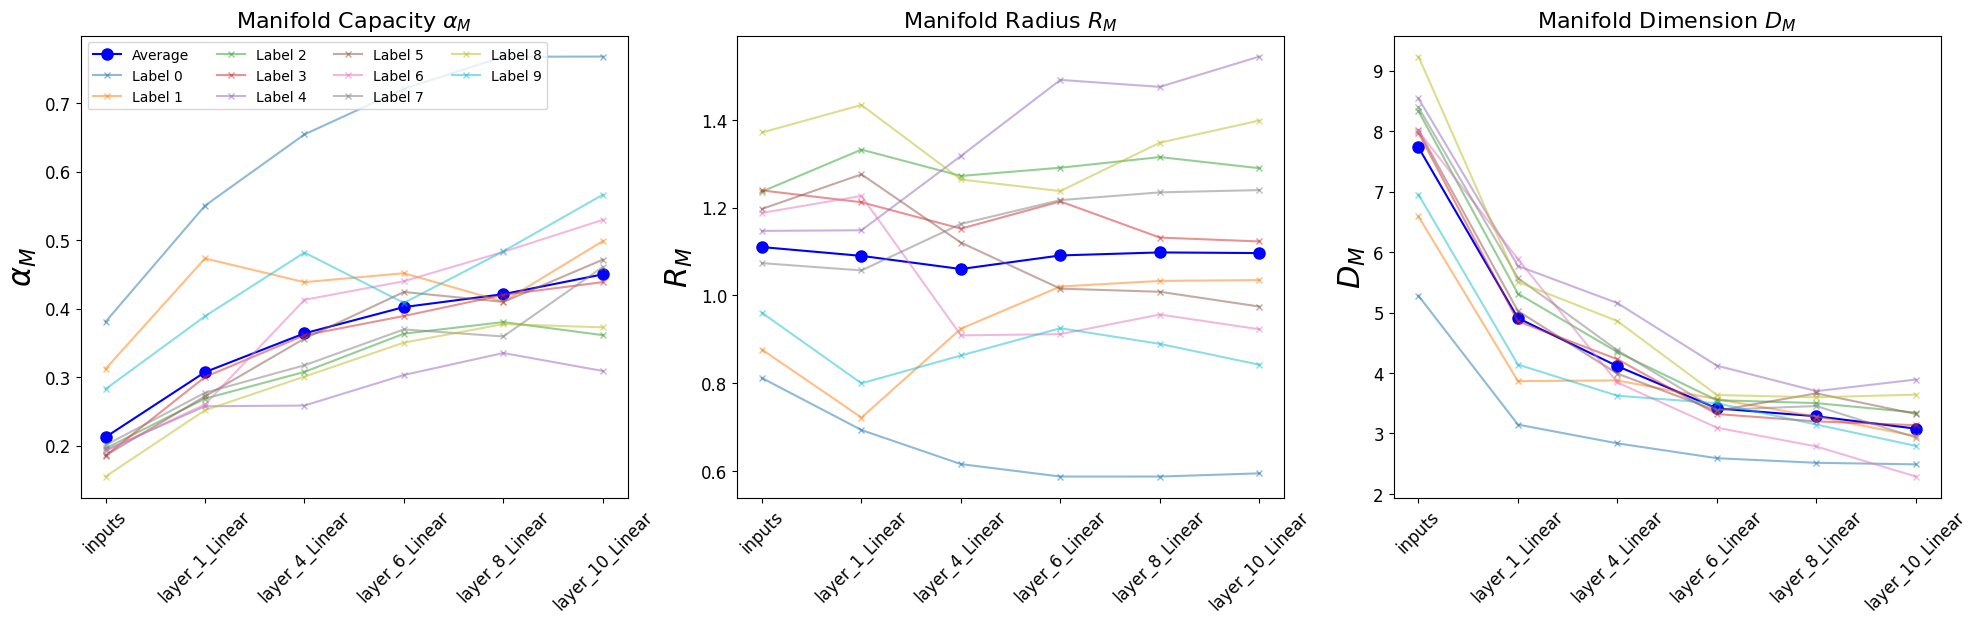

In [23]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

### 2.1.3 - CNN analysis

As you likely know, MLPs are generally pretty bad for image classification (MNIST just happens to be an "easy" dataset). Convolutional neural networks (CNNs) are a much better choice, and most of the best image classifiers from the past decade (e.g. ResNet) are CNNs. Convolutions also have nice geometric properties: they are **translation equivariant**, and when combined with some kind of global pooling (e.g. mean/max) a CNN can be translation **invariant**. 

In the cell below we define a basic CNN architecture sufficient for MNIST classification. Try training it and doing the same analysis as we did for the MLP above. In particular, try constructing an augmentation manifold from **translations**, and track how the capacity/radius/dimension of this manifold vary through layers of the network (particularly before/after the global pooling).

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        """
        Convolutional Neural Network for MNIST classification
        """
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 28x28 -> 28x28
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 28x28 -> 28x28
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),                             # 28x28 -> 14x14

            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 14x14 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),# 14x14 -> 14x14
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 14x14 -> 7x7

            # pooling
            nn.AdaptiveAvgPool2d((1, 1)),                 # 7x7 -> 1x1

            # fully connected layer,
            nn.Flatten(),
            nn.Linear(128, 10)
        )


    def forward(self, x):
        """Forward pass through the network"""
        return self.model(x)

Training Progress:   5%|▌         | 1/20 [00:17<05:27, 17.26s/it]

Epoch 1/20 - Train loss: 1.0746, Train acc: 0.7975, Val loss: 0.5394, Val acc: 0.9233


Training Progress:  10%|█         | 2/20 [00:25<03:34, 11.94s/it]

Epoch 2/20 - Train loss: 0.2643, Train acc: 0.9663, Val loss: 0.2033, Val acc: 0.9688


Training Progress:  15%|█▌        | 3/20 [00:34<02:56, 10.41s/it]

Epoch 3/20 - Train loss: 0.1323, Train acc: 0.9791, Val loss: 0.1957, Val acc: 0.9561


Training Progress:  20%|██        | 4/20 [00:42<02:33,  9.61s/it]

Epoch 4/20 - Train loss: 0.0908, Train acc: 0.9847, Val loss: 0.0948, Val acc: 0.9825


Training Progress:  25%|██▌       | 5/20 [00:50<02:15,  9.01s/it]

Epoch 5/20 - Train loss: 0.0682, Train acc: 0.9884, Val loss: 0.1576, Val acc: 0.9607


Training Progress:  30%|███       | 6/20 [00:58<02:03,  8.84s/it]

Epoch 6/20 - Train loss: 0.0570, Train acc: 0.9898, Val loss: 0.0937, Val acc: 0.9770


Training Progress:  35%|███▌      | 7/20 [01:06<01:50,  8.52s/it]

Epoch 7/20 - Train loss: 0.0457, Train acc: 0.9915, Val loss: 0.1088, Val acc: 0.9709


Training Progress:  40%|████      | 8/20 [01:15<01:41,  8.46s/it]

Epoch 8/20 - Train loss: 0.0398, Train acc: 0.9932, Val loss: 0.0843, Val acc: 0.9778


Training Progress:  45%|████▌     | 9/20 [01:23<01:31,  8.31s/it]

Epoch 9/20 - Train loss: 0.0329, Train acc: 0.9943, Val loss: 0.2465, Val acc: 0.9212


Training Progress:  50%|█████     | 10/20 [01:31<01:22,  8.26s/it]

Epoch 10/20 - Train loss: 0.0307, Train acc: 0.9947, Val loss: 0.1256, Val acc: 0.9663


Training Progress:  55%|█████▌    | 11/20 [01:39<01:13,  8.14s/it]

Epoch 11/20 - Train loss: 0.0254, Train acc: 0.9960, Val loss: 0.0863, Val acc: 0.9753


Training Progress:  60%|██████    | 12/20 [01:48<01:08,  8.60s/it]

Epoch 12/20 - Train loss: 0.0232, Train acc: 0.9961, Val loss: 0.4390, Val acc: 0.8392


Training Progress:  60%|██████    | 12/20 [01:56<01:17,  9.72s/it]

Epoch 13/20 - Train loss: 0.0202, Train acc: 0.9970, Val loss: 0.0861, Val acc: 0.9775
Early stop


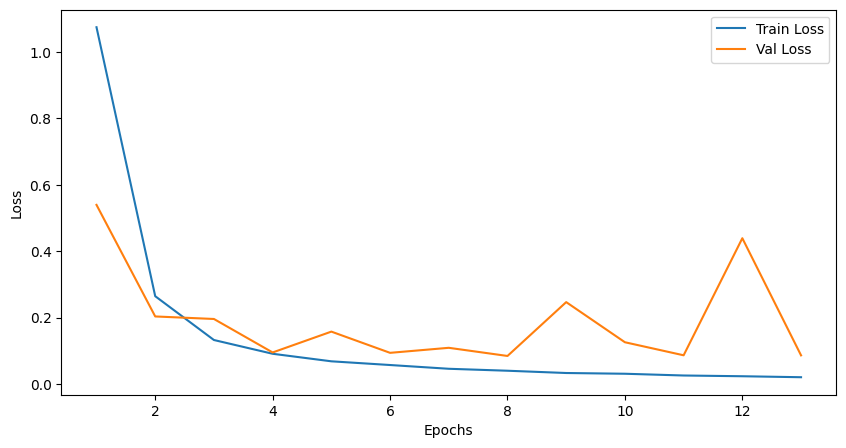

In [25]:
cnn_model = CNN()
# define train/val/test loaders, choose a batch size
batch_size = 1024
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
# Train the model
trained_cnn, train_losses, val_losses = train_model(
    model=cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=20,``
    patience=5,
    learning_rate=0.001
)

In [27]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000)
test_images, test_labels = next(iter(test_loader))
cnn_acts_trained, layer_names = extractor(trained_cnn, test_images, test_labels, layer_types=['Linear','Conv2d'])

alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(cnn_acts_trained)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Conv2d
Processing activations for layer: layer_4_Conv2d
Processing activations for layer: layer_8_Conv2d
Processing activations for layer: layer_11_Conv2d
Processing activations for layer: layer_17_Linear


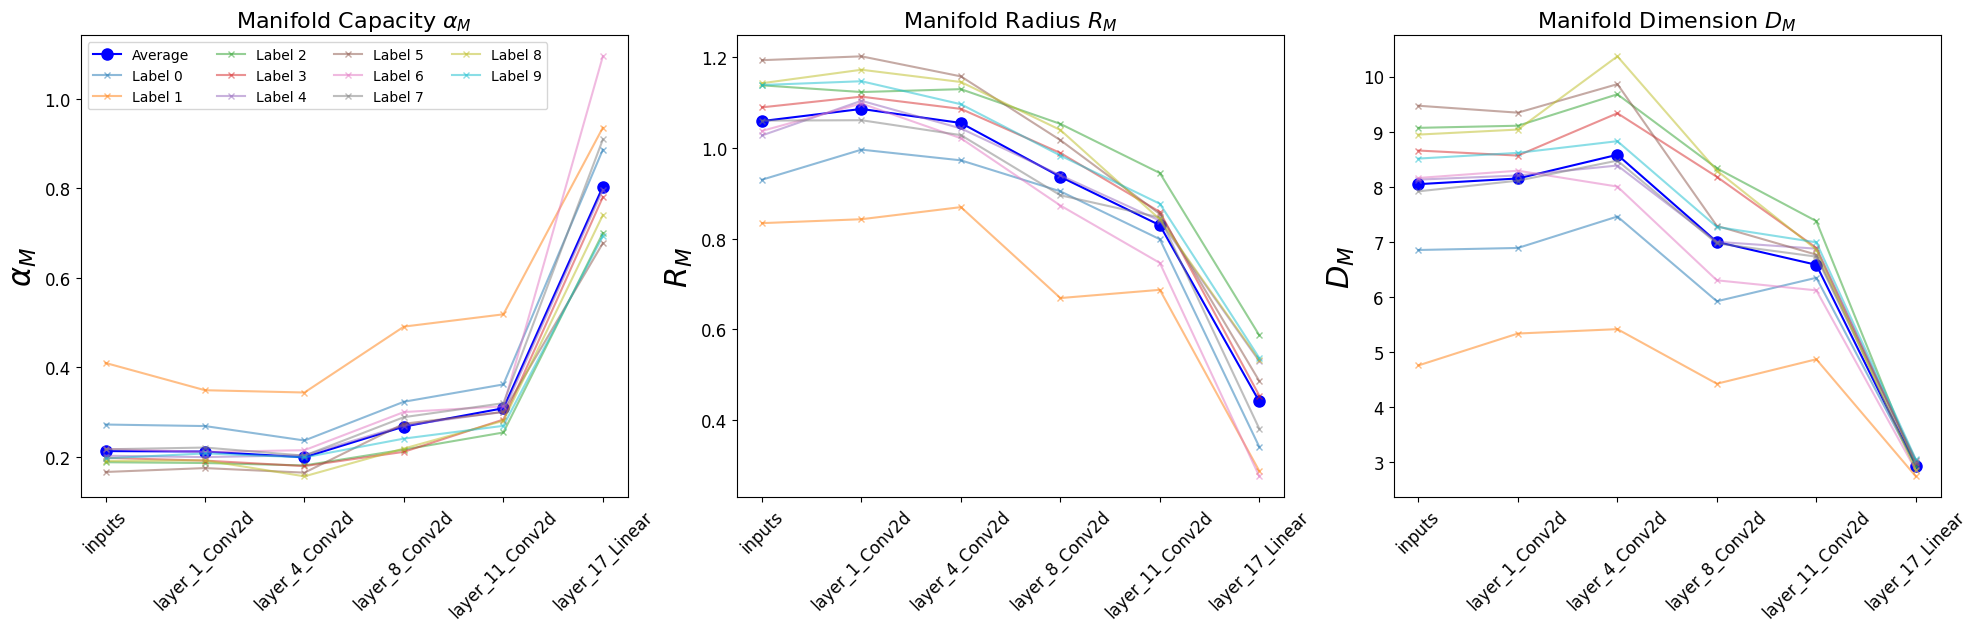

In [28]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

#### **Exercise**

Repeat the augmentation manifold analysis from above, this time including **translations** in addition to rotations/shears (use periodic boundaries or keep the translations moderate). What do you notice? How does this relate to the CNN architecture?

## 2.2 - Analyze a pre-trained ResNet on CIFAR-10
MNIST is just about the simplest image dataset out there. We can repeat this exercise on [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), a slightly more complicated dataset made from 32x32 color images of real-world objects. We won't bother training a classifier this time, instead using a pre-trained ResNet from [this repository](https://github.com/huyvnphan/PyTorch_CIFAR10).

In [29]:
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model.eval()

cifar10_mean = [0.4914, 0.4822, 0.4465]
cifar10_std = [0.2023, 0.1994, 0.2010]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=cifar10_mean, std=cifar10_std),
])
dataset = datasets.CIFAR10('./data',train=False, transform=transform, download=True)
ciar10_labels = np.arange(10)

Using cache found in /n/home11/sambt/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [30]:
# Define a dataloader for the test set and extract activations for 1000 test samples
test_loader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)
test_images, test_labels = next(iter(test_loader))
imagenette_labels = sorted(list(set(test_labels.numpy())))
activations_resnet, layer_names = extractor(model, test_images, test_labels, layer_types=['Linear','Conv2d'])

In [34]:
alphas, radii, dims, mean_alphas, mean_radii, mean_dims, labels = capacity_analysis(activations_resnet)

Processing activations for layer: inputs
Processing activations for layer: layer_1_Conv2d
Processing activations for layer: layer_4_Conv2d
Processing activations for layer: layer_7_Conv2d
Processing activations for layer: layer_9_Conv2d
Processing activations for layer: layer_12_Conv2d
Processing activations for layer: layer_14_Conv2d
Processing activations for layer: layer_17_Conv2d
Processing activations for layer: layer_19_Conv2d
Processing activations for layer: layer_22_Conv2d
Processing activations for layer: layer_24_Conv2d
Processing activations for layer: layer_26_Conv2d
Processing activations for layer: layer_29_Conv2d
Processing activations for layer: layer_31_Conv2d
Processing activations for layer: layer_34_Conv2d
Processing activations for layer: layer_36_Conv2d
Processing activations for layer: layer_39_Conv2d
Processing activations for layer: layer_41_Conv2d
Processing activations for layer: layer_43_Conv2d
Processing activations for layer: layer_46_Conv2d
Processing ac

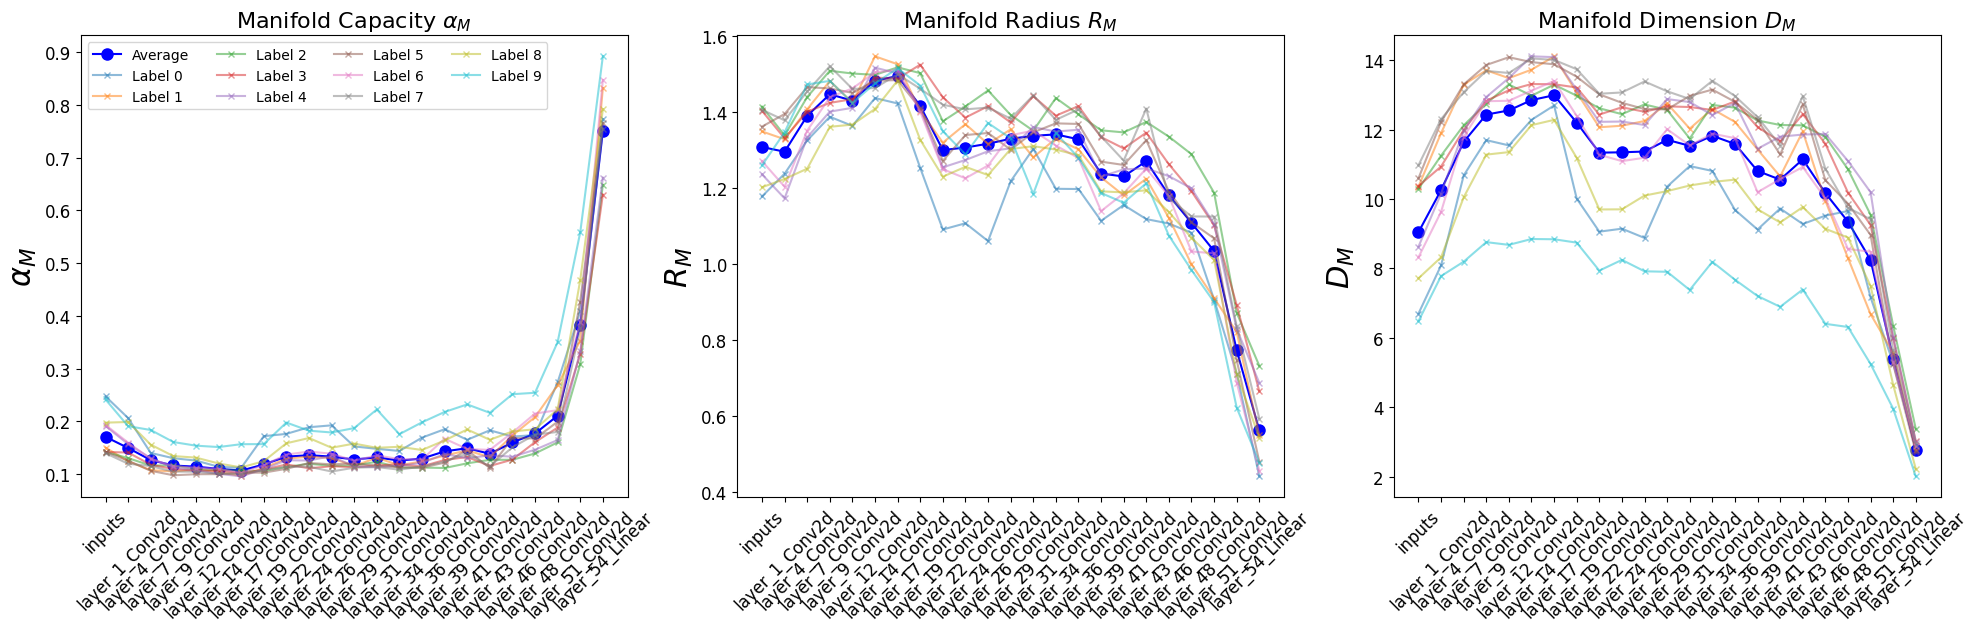

In [35]:
network_capacity_summary(alphas,radii,dims,mean_alphas,mean_radii,mean_dims,layer_names,labels)

What trends do you notice here? How do they compare to what you observed for the two "simple" models above?

#### **Exercise**

Investigate a few "augmentation manifolds" as above